# Late Fusion with Attention-Based Fusion

This notebook implements attention-based fusion for multimodal sentiment analysis:
- Audio: Wav2Vec2 features
- Vision: ResNet50 features
- Fusion: Attention mechanism to learn modality importance

The attention mechanism computes attention weights αi = softmax(Wa · [fv, fa])i over modalities,
then fuses: ffused = Σ αi * fi, and sends that to a classifier.


In [1]:
# =============================================================================
# STEP 0: SETUP, LIBRARIES & DATA PREPARATION
# =============================================================================
import sys

# Use pip from current kernel's Python executable
print(f"Using pip from {sys.executable}...")

# Install required libraries
!{sys.executable} -m pip install matplotlib seaborn tqdm librosa pandas scikit-learn torchvision opencv-python -q
!{sys.executable} -m pip install transformers[torch] accelerate -q

print("--- All libraries installed! ---")

import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import subprocess
import cv2
from PIL import Image
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification
from torchvision import transforms, models
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")


Using pip from /home/siyi/multimodal_final/multimodal-sentiment-analysis/venv/bin/python...

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
--- All libraries installed! ---


/home/siyi/multimodal_final/multimodal-sentiment-analysis/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Using device: cuda


## Data Loading and Preparation

Load audio and vision data, ensuring consistent video_id matching for fusion.


In [2]:
# =============================================================================
# STEP 1: LOAD DATA (Audio + Vision)
# =============================================================================

# Paths
RAVDESS_AUDIO_PATH = "/home/siyi/ravdess_audio"
RAVDESS_VIDEO_PATH = "/home/siyi/ravdess_dataset"
FRAMES_DIR = "/home/siyi/ravdess_frames"

# Emotion to sentiment mapping
emotion_to_sentiment = {
    'neutral': 0,   # neutral
    'calm': 0,      # neutral
    'happy': 1,     # positive
    'surprised': 1, # positive
    'sad': 2,       # negative
    'angry': 2,     # negative
    'fearful': 2,   # negative
    'disgust': 2    # negative
}

ravdess_emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

sentiment_list = ['neutral', 'positive', 'negative']

# --- Load Audio Data ---
print("Loading audio data...")
audio_data = []
for filename in os.listdir(RAVDESS_AUDIO_PATH):
    if filename.endswith('.wav'):
        video_id = os.path.splitext(filename)[0]
        parts = video_id.split('-')
        if len(parts) >= 3:
            emotion_code = parts[2]
            emotion = ravdess_emotion_map.get(emotion_code)
            if emotion:
                audio_data.append({
                    'video_id': video_id,
                    'audio_path': os.path.join(RAVDESS_AUDIO_PATH, filename),
                    'emotion': emotion,
                    'label': emotion_to_sentiment[emotion]
                })

audio_df = pd.DataFrame(audio_data)
audio_df = audio_df.sort_values('video_id').reset_index(drop=True)
print(f"✅ Loaded {len(audio_df)} audio files")

# --- Load Vision Data (frames) ---
print("Loading vision data...")
vision_data = []
for filename in os.listdir(FRAMES_DIR):
    if filename.endswith('.jpg'):
        video_id = filename.split('_frame_')[0]
        parts = video_id.split('-')
        if len(parts) >= 3:
            emotion_code = parts[2]
            emotion = ravdess_emotion_map.get(emotion_code)
            if emotion:
                vision_data.append({
                    'video_id': video_id,
                    'frame_path': os.path.join(FRAMES_DIR, filename),
                    'emotion': emotion,
                    'label': emotion_to_sentiment[emotion]
                })

vision_df = pd.DataFrame(vision_data)
print(f"✅ Loaded {len(vision_df)} vision frames")

# --- Group vision frames by video_id ---
vision_df_grouped = vision_df.groupby('video_id').agg({
    'frame_path': list,
    'emotion': 'first',
    'label': 'first'
}).reset_index()

frames_per_video = vision_df_grouped['frame_path'].apply(len)
print(f"✅ Frames per video: min={frames_per_video.min()}, max={frames_per_video.max()}, mean={frames_per_video.mean():.1f}")
print(f"✅ Grouped to {len(vision_df_grouped)} unique videos")

# --- Merge audio and vision data by video_id ---
fusion_df = audio_df.merge(
    vision_df_grouped[['video_id', 'frame_path', 'emotion', 'label']],
    on='video_id',
    suffixes=('_audio', '_vision'),
    how='inner'
)

# Verify labels match
assert (fusion_df['label_audio'] == fusion_df['label_vision']).all(), "Label mismatch!"
fusion_df['label'] = fusion_df['label_audio']
fusion_df = fusion_df.drop(['label_audio', 'label_vision'], axis=1)

print(f"✅ Merged dataset: {len(fusion_df)} samples with both audio and vision")

# --- Split by actor ID ---
fusion_df['actor_id'] = fusion_df['video_id'].apply(lambda x: int(x.split('-')[-1]))

train_actor_ids = list(range(1, 19))
val_actor_ids = list(range(19, 22))
test_actor_ids = list(range(22, 25))

train_df = fusion_df[fusion_df['actor_id'].isin(train_actor_ids)].copy().reset_index(drop=True)
val_df = fusion_df[fusion_df['actor_id'].isin(val_actor_ids)].copy().reset_index(drop=True)
test_df = fusion_df[fusion_df['actor_id'].isin(test_actor_ids)].copy().reset_index(drop=True)

# Verify no data leakage
train_video_ids = set(train_df['video_id'].unique())
val_video_ids = set(val_df['video_id'].unique())
test_video_ids = set(test_df['video_id'].unique())

print(f"\n🔍 Data split verification:")
print(f"  Train videos: {len(train_video_ids)}")
print(f"  Val videos: {len(val_video_ids)}")
print(f"  Test videos: {len(test_video_ids)}")
print(f"  Train-Val overlap: {len(train_video_ids & val_video_ids)}")
print(f"  Train-Test overlap: {len(train_video_ids & test_video_ids)}")
print(f"  Val-Test overlap: {len(val_video_ids & test_video_ids)}")

if len(train_video_ids & val_video_ids) > 0 or len(train_video_ids & test_video_ids) > 0 or len(val_video_ids & test_video_ids) > 0:
    print("  ⚠️  WARNING: Data leakage detected!")
else:
    print("  ✅ No data leakage detected.")

print(f"\n📊 Data split:")
print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")


Loading audio data...
✅ Loaded 2452 audio files
Loading vision data...
✅ Loaded 11428 vision frames
✅ Frames per video: min=4, max=5, mean=4.7
✅ Grouped to 2452 unique videos
✅ Merged dataset: 2452 samples with both audio and vision

🔍 Data split verification:
  Train videos: 1828
  Val videos: 312
  Test videos: 312
  Train-Val overlap: 0
  Train-Test overlap: 0
  Val-Test overlap: 0
  ✅ No data leakage detected.

📊 Data split:
Train: 1828 | Val: 312 | Test: 312


## Load Pre-trained Models and Extract Features

Load the pre-trained audio and vision models, modify them to extract features instead of classifications.


In [3]:
# =============================================================================
# STEP 2: LOAD PRE-TRAINED MODELS (Feature Extractors)
# =============================================================================

# --- Load Audio Model (Wav2Vec2) ---
print("Loading audio model (Wav2Vec2)...")
AUDIO_MODEL_PATH = "/home/siyi/multimodal_final/multimodal-sentiment-analysis/notebooks/best_wav2vec2_two_stage.pth"
MODEL_CHECKPOINT = "facebook/wav2vec2-base"
TARGET_SAMPLING_RATE = 16000

from transformers import AutoFeatureExtractor
audio_feature_extractor = AutoFeatureExtractor.from_pretrained(MODEL_CHECKPOINT)

# Load model
audio_model = AutoModelForAudioClassification.from_pretrained(
    MODEL_CHECKPOINT, 
    num_labels=3
).to(device)

# Load weights
if os.path.exists(AUDIO_MODEL_PATH):
    audio_model.load_state_dict(torch.load(AUDIO_MODEL_PATH, map_location=device))
    print("✅ Loaded audio model weights")
else:
    print("⚠️  Audio model weights not found, using pre-trained only")

# Freeze audio model and use as feature extractor
for param in audio_model.parameters():
    param.requires_grad = False
audio_model.eval()

# Get audio feature dimension
audio_feature_dim = audio_model.projector.out_features
print(f"Audio feature dimension: {audio_feature_dim}")

# --- Load Vision Model (ResNet50) ---
print("\nLoading vision model (ResNet50)...")
VISION_MODEL_PATH = "/home/siyi/multimodal_final/multimodal-sentiment-analysis/model_weights/resnet50_fer2013_sentiment.pth"

# Load ResNet50
vision_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = vision_model.fc.in_features
vision_model.fc = nn.Linear(num_ftrs, 3)  # 3 classes

# Move model to device BEFORE loading weights
vision_model = vision_model.to(device)

# Load weights
if os.path.exists(VISION_MODEL_PATH):
    vision_model.load_state_dict(torch.load(VISION_MODEL_PATH, map_location=device))
    print("✅ Loaded vision model weights")
else:
    print("⚠️  Vision model weights not found, using ImageNet pre-trained only")

# Freeze vision model and use as feature extractor
for param in vision_model.parameters():
    param.requires_grad = False
vision_model.eval()

# Create a feature extractor function for ResNet50
def extract_resnet_features(model, image):
    """Extract features from ResNet50 before the fc layer"""
    x = model.conv1(image)
    x = model.bn1(x)
    x = model.relu(x)
    x = model.maxpool(x)
    x = model.layer1(x)
    x = model.layer2(x)
    x = model.layer3(x)
    x = model.layer4(x)
    x = model.avgpool(x)
    x = torch.flatten(x, 1)
    return x

# Get vision feature dimension
vision_feature_dim = num_ftrs  # 2048 for ResNet50
print(f"Vision feature dimension: {vision_feature_dim}")

print(f"\n✅ Feature dimensions: Audio={audio_feature_dim}, Vision={vision_feature_dim}")


Loading audio model (Wav2Vec2)...


/home/siyi/multimodal_final/multimodal-sentiment-analysis/venv/lib/python3.13/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded audio model weights
Audio feature dimension: 256

Loading vision model (ResNet50)...
✅ Loaded vision model weights
Vision feature dimension: 2048

✅ Feature dimensions: Audio=256, Vision=2048


## Dataset for Feature Extraction

Create dataset that extracts features from both audio and vision models separately (not concatenated).


In [4]:
# =============================================================================
# STEP 3: DATASET FOR FEATURE EXTRACTION
# =============================================================================

class FusionDataset(Dataset):
    """Dataset that extracts features from both audio and vision models separately"""
    
    def __init__(self, df, audio_model, vision_model, audio_feature_extractor, 
                 vision_transform, extract_resnet_fn, max_duration_s=5.0):
        self.df = df
        self.audio_model = audio_model
        self.vision_model = vision_model
        self.audio_feature_extractor = audio_feature_extractor
        self.vision_transform = vision_transform
        self.extract_resnet_fn = extract_resnet_fn
        self.max_length = int(max_duration_s * TARGET_SAMPLING_RATE)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        audio_path = row['audio_path']
        frame_paths = row['frame_path']
        label = row['label']
        
        if isinstance(frame_paths, str):
            frame_paths = [frame_paths]
        
        # Extract audio features
        try:
            audio, sr = librosa.load(audio_path, sr=None)
            if sr != TARGET_SAMPLING_RATE:
                audio = librosa.resample(audio, orig_sr=sr, target_sr=TARGET_SAMPLING_RATE)
            
            audio_tensor = torch.tensor(audio).float()
            if len(audio_tensor) > self.max_length:
                audio_tensor = audio_tensor[:self.max_length]
            else:
                pad_len = self.max_length - len(audio_tensor)
                audio_tensor = torch.nn.functional.pad(audio_tensor, (0, pad_len))
            
            inputs = self.audio_feature_extractor(
                audio_tensor.numpy(),
                sampling_rate=TARGET_SAMPLING_RATE,
                max_length=self.max_length,
                truncation=True,
                padding="max_length",
                return_attention_mask=True,
                return_tensors="pt"
            )
            
            input_values = inputs.input_values.to(device)
            attention_mask = inputs.attention_mask.to(device)
            
            with torch.no_grad():
                audio_outputs = self.audio_model.wav2vec2(input_values, attention_mask=attention_mask)
                audio_features = audio_outputs.last_hidden_state.mean(dim=1)
                audio_features = self.audio_model.projector(audio_features)
                audio_features = audio_features.squeeze(0).cpu()
        except Exception as e:
            print(f"Error processing audio {audio_path}: {e}")
            audio_features = torch.zeros(audio_feature_dim)
        
        # Extract vision features from multiple frames
        vision_features_list = []
        for frame_path in frame_paths:
            try:
                image = Image.open(frame_path).convert('RGB')
                image = self.vision_transform(image).unsqueeze(0).to(device)
                
                with torch.no_grad():
                    frame_features = self.extract_resnet_fn(self.vision_model, image)
                    vision_features_list.append(frame_features.squeeze(0).cpu())
            except Exception as e:
                print(f"Error processing vision frame {frame_path}: {e}")
                vision_features_list.append(torch.zeros(vision_feature_dim))
        
        # Average pool over frames
        if len(vision_features_list) > 0:
            vision_features = torch.stack(vision_features_list).mean(dim=0)
        else:
            vision_features = torch.zeros(vision_feature_dim)
        
        # Return separate features (not concatenated) for attention fusion
        return audio_features, vision_features, label

# Vision transform
vision_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets
print("Creating datasets...")
train_fusion_dataset = FusionDataset(train_df, audio_model, vision_model, 
                                     audio_feature_extractor, vision_transform, extract_resnet_features)
val_fusion_dataset = FusionDataset(val_df, audio_model, vision_model, 
                                   audio_feature_extractor, vision_transform, extract_resnet_features)
test_fusion_dataset = FusionDataset(test_df, audio_model, vision_model, 
                                    audio_feature_extractor, vision_transform, extract_resnet_features)

print("✅ Datasets created")


Creating datasets...
✅ Datasets created


## Attention-Based Fusion Model

Implement attention mechanism for modality fusion:
- Compute attention weights: αi = softmax(Wa · [fv, fa])i
- Fuse features: ffused = Σ αi * fi
- Classify with MLP


In [5]:
# =============================================================================
# STEP 4: ATTENTION-BASED FUSION MODEL
# =============================================================================

class AttentionFusionModel(nn.Module):
    """Attention-based fusion model for multimodal sentiment analysis"""
    
    def __init__(self, audio_dim, vision_dim, num_classes=3, hidden_dim=256, dropout=0.5):
        super(AttentionFusionModel, self).__init__()
        
        self.audio_dim = audio_dim
        self.vision_dim = vision_dim
        
        # Project both modalities to the same dimension for attention
        self.audio_proj = nn.Linear(audio_dim, hidden_dim)
        self.vision_proj = nn.Linear(vision_dim, hidden_dim)
        
        # Attention mechanism
        # Compute attention weights: αi = softmax(Wa · [fv, fa])i
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),  # Wa in the formula
            nn.Tanh(),
            nn.Linear(hidden_dim, 2),  # 2 modalities: audio and vision
            nn.Softmax(dim=-1)  # Softmax to get attention weights
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )
    
    def forward(self, audio_features, vision_features):
        """
        Args:
            audio_features: [batch_size, audio_dim]
            vision_features: [batch_size, vision_dim]
        Returns:
            logits: [batch_size, num_classes]
            attention_weights: [batch_size, 2]
        """
        batch_size = audio_features.size(0)
        
        # Project to same dimension
        audio_proj = self.audio_proj(audio_features)  # [batch, hidden_dim]
        vision_proj = self.vision_proj(vision_features)  # [batch, hidden_dim]
        
        # Concatenate for attention computation: [fv, fa]
        concat_features = torch.cat([vision_proj, audio_proj], dim=1)  # [batch, hidden_dim * 2]
        
        # Compute attention weights: αi = softmax(Wa · [fv, fa])i
        attention_weights = self.attention(concat_features)  # [batch, 2]
        
        # Apply attention weights: ffused = Σ αi * fi
        # attention_weights[:, 0] for vision, attention_weights[:, 1] for audio
        vision_weighted = vision_proj * attention_weights[:, 0:1]  # [batch, hidden_dim]
        audio_weighted = audio_proj * attention_weights[:, 1:2]  # [batch, hidden_dim]
        
        # Fused features
        fused_features = vision_weighted + audio_weighted  # [batch, hidden_dim]
        
        # Classify
        logits = self.classifier(fused_features)  # [batch, num_classes]
        
        return logits, attention_weights

# Create model
fusion_model = AttentionFusionModel(
    audio_dim=audio_feature_dim,
    vision_dim=vision_feature_dim,
    num_classes=3,
    hidden_dim=256,
    dropout=0.5
).to(device)

print("✅ Attention-based fusion model created")
print(f"   Audio feature dim: {audio_feature_dim}")
print(f"   Vision feature dim: {vision_feature_dim}")
print(f"   Hidden dim: 256")
print(f"   Output dim: 3 (sentiment classes)")


✅ Attention-based fusion model created
   Audio feature dim: 256
   Vision feature dim: 2048
   Hidden dim: 256
   Output dim: 3 (sentiment classes)


## Create DataLoaders

Create DataLoaders for training and evaluation.


In [6]:
# =============================================================================
# STEP 5: CREATE DATALOADERS
# =============================================================================

def collate_fn(batch):
    """Custom collate function to handle separate audio and vision features"""
    audio_features = torch.stack([item[0] for item in batch])
    vision_features = torch.stack([item[1] for item in batch])
    labels = torch.tensor([item[2] for item in batch], dtype=torch.long)
    return audio_features, vision_features, labels

batch_size = 32
train_loader = DataLoader(train_fusion_dataset, batch_size=batch_size, shuffle=True, 
                          collate_fn=collate_fn, num_workers=0)
val_loader = DataLoader(val_fusion_dataset, batch_size=batch_size, shuffle=False, 
                        collate_fn=collate_fn, num_workers=0)
test_loader = DataLoader(test_fusion_dataset, batch_size=batch_size, shuffle=False, 
                         collate_fn=collate_fn, num_workers=0)

print("✅ DataLoaders created")


✅ DataLoaders created


## Training Setup

Setup loss function, optimizer, and scheduler.


In [ ]:
# =============================================================================
# STEP 6: TRAINING SETUP
# =============================================================================

# Class weights for imbalanced dataset
train_labels = train_df['label'].tolist()
class_weights_np = compute_class_weight(
    'balanced',
    classes=np.arange(3),
    y=train_labels
)
class_weights_np[0] *= 1.2  # Neutral
class_weights_np[1] *= 1.1  # Positive
class_weights_np[2] *= 0.9  # Negative class (reduce weight slightly)
class_weights = torch.tensor(class_weights_np, dtype=torch.float32).to(device)

print("Class weights:")
for sentiment, w in zip(sentiment_list, class_weights.cpu().numpy()):
    print(f"  {sentiment:10s}: {w:.4f}")

# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
optimizer = torch.optim.AdamW(fusion_model.parameters(), lr=5e-4, weight_decay=0.05)

# Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

print("\n✅ Training setup complete")
print(f"   Loss: CrossEntropyLoss with class weights")
print(f"   Optimizer: AdamW (lr=1e-3, weight_decay=0.01)")
print(f"   Scheduler: CosineAnnealingLR")


Class weights:
  neutral   : 1.7410
  positive  : 1.5808
  negative  : 0.5573

✅ Training setup complete
   Loss: CrossEntropyLoss with class weights
   Optimizer: AdamW (lr=1e-3, weight_decay=0.01)
   Scheduler: CosineAnnealingLR


## Training Loop

Train the attention-based fusion model.


In [8]:
# =============================================================================
# STEP 7: TRAINING LOOP
# =============================================================================

num_epochs = 20
patience = 3
best_val_acc = 0.0
counter = 0

train_accs = []
val_accs = []
train_losses = []
val_losses = []

start_time = time.time()

for epoch in range(num_epochs):
    # Training
    fusion_model.train()
    train_correct = 0
    train_total = 0
    train_loss = 0.0
    
    for audio_features, vision_features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        audio_features = audio_features.to(device)
        vision_features = vision_features.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs, attention_weights = fusion_model(audio_features, vision_features)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(fusion_model.parameters(), 1.0)
        optimizer.step()
        
        train_loss += loss.item()
        preds = outputs.argmax(dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
    
    # Validation
    fusion_model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    
    with torch.no_grad():
        for audio_features, vision_features, labels in val_loader:
            audio_features = audio_features.to(device)
            vision_features = vision_features.to(device)
            labels = labels.to(device)
            
            outputs, attention_weights = fusion_model(audio_features, vision_features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    train_acc = train_correct / train_total
    val_acc = val_correct / val_total
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    scheduler.step()
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(fusion_model.state_dict(), "best_attention_fusion_model.pth")
        counter = 0
        print(f"  🔥 Saved best model! (Val Acc: {val_acc:.4f})")
    else:
        counter += 1
        if counter >= patience:
            print(f"  Early stopping at epoch {epoch+1}")
            break

end_time = time.time()
total_time = end_time - start_time

print("\n" + "="*60)
print("Training Completed!")
print("="*60)
print(f"Final Train Accuracy: {train_accs[-1]:.4f} ({train_accs[-1]*100:.2f}%)")
print(f"Final Val Accuracy: {val_accs[-1]:.4f} ({val_accs[-1]*100:.2f}%)")
print(f"Best Val Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"Total Training Time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")


Epoch 1/20: 100%|██████████| 58/58 [02:34<00:00,  2.66s/it]


Epoch 1/20 | Train Loss: 0.2001 | Train Acc: 0.9568 | Val Loss: 0.5521 | Val Acc: 0.8237
  🔥 Saved best model! (Val Acc: 0.8237)


Epoch 2/20: 100%|██████████| 58/58 [02:33<00:00,  2.64s/it]


Epoch 2/20 | Train Loss: 0.0797 | Train Acc: 0.9907 | Val Loss: 0.5802 | Val Acc: 0.8429
  🔥 Saved best model! (Val Acc: 0.8429)


Epoch 3/20: 100%|██████████| 58/58 [02:32<00:00,  2.64s/it]


Epoch 3/20 | Train Loss: 0.0251 | Train Acc: 0.9967 | Val Loss: 0.4436 | Val Acc: 0.8878
  🔥 Saved best model! (Val Acc: 0.8878)


Epoch 4/20: 100%|██████████| 58/58 [02:32<00:00,  2.63s/it]


Epoch 4/20 | Train Loss: 0.0251 | Train Acc: 0.9945 | Val Loss: 0.6002 | Val Acc: 0.8590


Epoch 5/20: 100%|██████████| 58/58 [02:32<00:00,  2.63s/it]


Epoch 5/20 | Train Loss: 0.0260 | Train Acc: 0.9956 | Val Loss: 0.4849 | Val Acc: 0.8654


Epoch 6/20: 100%|██████████| 58/58 [02:32<00:00,  2.63s/it]


Epoch 6/20 | Train Loss: 0.0326 | Train Acc: 0.9967 | Val Loss: 0.5129 | Val Acc: 0.8718
  Early stopping at epoch 6

Training Completed!
Final Train Accuracy: 0.9967 (99.67%)
Final Val Accuracy: 0.8718 (87.18%)
Best Val Accuracy: 0.8878 (88.78%)
Total Training Time: 1074.47 seconds (17.91 minutes)


## Evaluation

Evaluate the attention-based fusion model on the test set.


--- Evaluating Attention-Based Fusion Model on Test Set ---


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 10/10 [00:27<00:00,  2.79s/it]


--- Attention-Based Fusion Model Classification Report (3 Sentiment Classes) ---
              precision    recall  f1-score   support

     neutral       0.91      0.82      0.86        72
    positive       0.94      0.88      0.91        72
    negative       0.92      0.99      0.95       168

    accuracy                           0.92       312
   macro avg       0.92      0.89      0.91       312
weighted avg       0.92      0.92      0.92       312


--- Detailed Metrics ---
Accuracy: 0.9231

Per-class metrics:
  neutral   : Precision=0.9077, Recall=0.8194, F1=0.8613, Support=72
  positive  : Precision=0.9403, Recall=0.8750, F1=0.9065, Support=72
  negative  : Precision=0.9222, Recall=0.9881, F1=0.9540, Support=168

Macro average: Precision=0.9234, Recall=0.8942, F1=0.9073
Weighted average: Precision=0.9230, Recall=0.9231, F1=0.9217


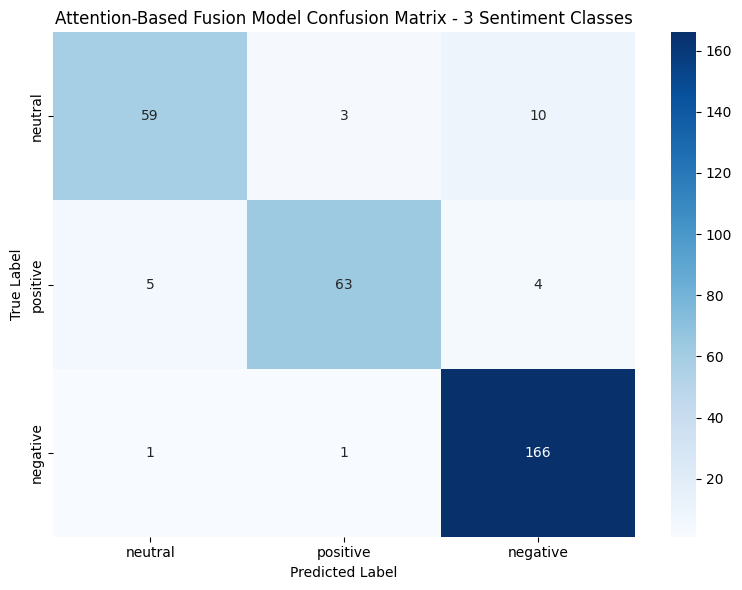


--- Attention Weight Analysis ---
Average Vision Attention Weight: 0.4538
Average Audio Attention Weight: 0.5462

This shows how much the model relies on each modality for classification.


In [11]:
# =============================================================================
# STEP 8: EVALUATION
# =============================================================================

print("--- Evaluating Attention-Based Fusion Model on Test Set ---")

# Load best model
fusion_model.load_state_dict(torch.load("best_attention_fusion_model.pth"))
fusion_model.eval()

all_preds = []
all_labels = []
all_attention_weights = []

with torch.no_grad():
    for audio_features, vision_features, labels in tqdm(test_loader, desc="Evaluating"):
        audio_features = audio_features.to(device)
        vision_features = vision_features.to(device)
        
        outputs, attention_weights = fusion_model(audio_features, vision_features)
        preds = outputs.argmax(dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_attention_weights.append(attention_weights.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, support = precision_recall_fscore_support(
    all_labels, all_preds, average=None, zero_division=0
)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    all_labels, all_preds, average='macro', zero_division=0
)
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
    all_labels, all_preds, average='weighted', zero_division=0
)

# Classification Report
print("\n--- Attention-Based Fusion Model Classification Report (3 Sentiment Classes) ---")
print(classification_report(all_labels, all_preds, target_names=sentiment_list))

# Print detailed metrics
print("\n--- Detailed Metrics ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"\nPer-class metrics:")
for i, sentiment in enumerate(sentiment_list):
    print(f"  {sentiment:10s}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}, Support={support[i]}")
print(f"\nMacro average: Precision={precision_macro:.4f}, Recall={recall_macro:.4f}, F1={f1_macro:.4f}")
print(f"Weighted average: Precision={precision_weighted:.4f}, Recall={recall_weighted:.4f}, F1={f1_weighted:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=sentiment_list,
    yticklabels=sentiment_list
)
plt.title('Attention-Based Fusion Model Confusion Matrix - 3 Sentiment Classes')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Analyze attention weights
all_attention_weights = np.concatenate(all_attention_weights, axis=0)
avg_vision_attention = all_attention_weights[:, 0].mean()
avg_audio_attention = all_attention_weights[:, 1].mean()

print("\n--- Attention Weight Analysis ---")
print(f"Average Vision Attention Weight: {avg_vision_attention:.4f}")
print(f"Average Audio Attention Weight: {avg_audio_attention:.4f}")
print(f"\nThis shows how much the model relies on each modality for classification.")


## Missing Modality Evaluation

Evaluate the model when one modality is missing (set to zero).


In [12]:
# =============================================================================
# STEP 9: MISSING MODALITY EVALUATION
# =============================================================================

print("="*70)
print("EVALUATING MISSING MODALITY SCENARIOS")
print("="*70)

def evaluate_with_missing_modality(model, loader, missing_modality='none'):
    """Evaluate model with missing modality"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for audio_features, vision_features, labels in tqdm(loader, desc=f"Evaluating {missing_modality}"):
            audio_features = audio_features.to(device)
            vision_features = vision_features.to(device)
            labels = labels.to(device)
            
            # Set missing modality to zero
            if missing_modality == 'audio':
                audio_features = torch.zeros_like(audio_features)
            elif missing_modality == 'vision':
                vision_features = torch.zeros_like(vision_features)
            
            outputs, _ = model(audio_features, vision_features)
            preds = outputs.argmax(dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )
    
    return {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro
    }

# Evaluate full fusion
print("\n" + "-"*70)
print("1. FULL FUSION (Audio + Vision)")
print("-"*70)
results_full = evaluate_with_missing_modality(fusion_model, test_loader, 'none')

# Evaluate audio-only
print("\n" + "-"*70)
print("2. AUDIO-ONLY (Vision features set to zero)")
print("-"*70)
results_audio = evaluate_with_missing_modality(fusion_model, test_loader, 'vision')

# Evaluate vision-only
print("\n" + "-"*70)
print("3. VISION-ONLY (Audio features set to zero)")
print("-"*70)
results_vision = evaluate_with_missing_modality(fusion_model, test_loader, 'audio')

# Print comparison table
print("\n" + "="*70)
print("COMPARISON OF ALL SCENARIOS")
print("="*70)

print(f"\n{'Scenario':<20} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-"*70)
print(f"{'Full Fusion':<20} {results_full['accuracy']:<12.4f} {results_full['precision_macro']:<12.4f} {results_full['recall_macro']:<12.4f} {results_full['f1_macro']:<12.4f}")
print(f"{'Audio-Only':<20} {results_audio['accuracy']:<12.4f} {results_audio['precision_macro']:<12.4f} {results_audio['recall_macro']:<12.4f} {results_audio['f1_macro']:<12.4f}")
print(f"{'Vision-Only':<20} {results_vision['accuracy']:<12.4f} {results_vision['precision_macro']:<12.4f} {results_vision['recall_macro']:<12.4f} {results_vision['f1_macro']:<12.4f}")

# Calculate performance drop
audio_drop = results_full['accuracy'] - results_audio['accuracy']
vision_drop = results_full['accuracy'] - results_vision['accuracy']

print("\n" + "="*70)
print("PERFORMANCE DROP ANALYSIS")
print("="*70)
print(f"Full Fusion Accuracy: {results_full['accuracy']:.4f} ({results_full['accuracy']*100:.2f}%)")
print(f"Audio-Only Accuracy:  {results_audio['accuracy']:.4f} ({results_audio['accuracy']*100:.2f}%)")
print(f"  → Performance drop: {audio_drop:.4f} ({audio_drop*100:.2f} percentage points)")
print(f"Vision-Only Accuracy: {results_vision['accuracy']:.4f} ({results_vision['accuracy']*100:.2f}%)")
print(f"  → Performance drop: {vision_drop:.4f} ({vision_drop*100:.2f} percentage points)")


EVALUATING MISSING MODALITY SCENARIOS

----------------------------------------------------------------------
1. FULL FUSION (Audio + Vision)
----------------------------------------------------------------------


Evaluating none: 100%|██████████| 10/10 [00:28<00:00,  2.80s/it]



----------------------------------------------------------------------
2. AUDIO-ONLY (Vision features set to zero)
----------------------------------------------------------------------


Evaluating vision: 100%|██████████| 10/10 [00:27<00:00,  2.79s/it]



----------------------------------------------------------------------
3. VISION-ONLY (Audio features set to zero)
----------------------------------------------------------------------


Evaluating audio: 100%|██████████| 10/10 [00:28<00:00,  2.82s/it]


COMPARISON OF ALL SCENARIOS

Scenario             Accuracy     Precision    Recall       F1-Score    
----------------------------------------------------------------------
Full Fusion          0.9231       0.9234       0.8942       0.9073      
Audio-Only           0.8173       0.8033       0.8313       0.8078      
Vision-Only          0.7564       0.7099       0.6667       0.6809      

PERFORMANCE DROP ANALYSIS
Full Fusion Accuracy: 0.9231 (92.31%)
Audio-Only Accuracy:  0.8173 (81.73%)
  → Performance drop: 0.1058 (10.58 percentage points)
Vision-Only Accuracy: 0.7564 (75.64%)
  → Performance drop: 0.1667 (16.67 percentage points)
